In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [16]:
path = Config().data_path()/'mnist'

In [17]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz')]

In [18]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

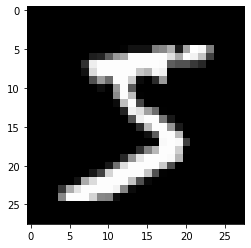

In [19]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [20]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [21]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [22]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [23]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [24]:
model = Mnist_Logistic().cuda()

In [25]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [26]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [27]:
model(x).shape

torch.Size([64, 10])

In [28]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [29]:
lr=2e-2

In [30]:
loss_func = nn.CrossEntropyLoss()

In [31]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [32]:
losses = [update(x,y,lr) for x,y in data.train_dl]

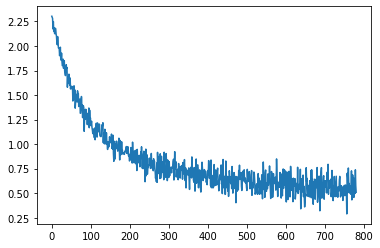

In [33]:
plt.plot(losses);

In [34]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        # use 2 linear layers
        # first layer has output of 50
        self.lin1 = nn.Linear(784, 50, bias=True)
        # second layer has input of 50 and output of 10 (since it's the number of classes we're predicting)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        # first layer
        x = self.lin1(xb)
        # calculate relu
        x = F.relu(x)
        return self.lin2(x) # second layer

In [35]:
model = Mnist_NN().cuda()

In [36]:
losses = [update(x,y,lr) for x,y in data.train_dl]

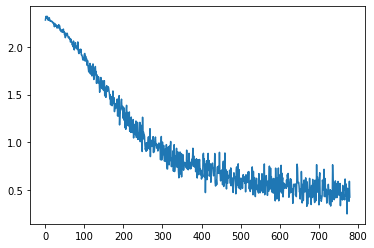

In [37]:
plt.plot(losses);

In [38]:
model = Mnist_NN().cuda()

In [42]:
def update(x,y,lr):
    # take model.parameters() and optimize them using Adam
    opt = optim.SGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [43]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

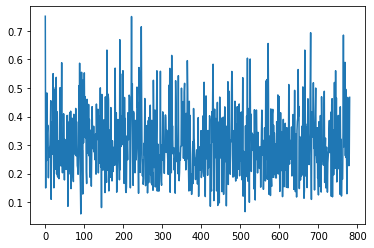

In [44]:
plt.plot(losses);

In [45]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [ ]:
%debug

> /opt/anaconda3/lib/python3.7/gzip.py(482)read()
    480                 break
    481             if buf == b"":
--> 482                 raise EOFError("Compressed file ended before the "
    483                                "end-of-stream marker was reached")
    484 



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


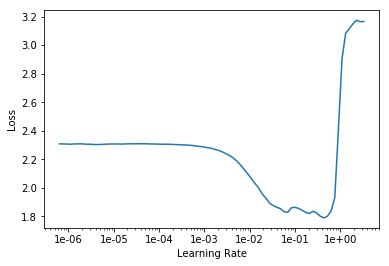

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.129131,0.125927,0.963500


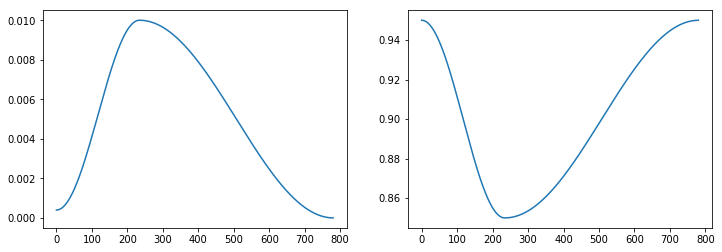

In [ ]:
learn.recorder.plot_lr(show_moms=True)

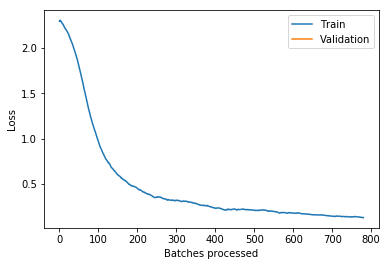

In [ ]:
learn.recorder.plot_losses()

## fin